<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/xor_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Using Graph Neural Networks
By Fayyaz Minhas.


This tutorial demonstrates how to model the XOR problem as a graph classification task using PyTorch Geometric. Each graph represents two binary inputs as nodes and the edges between them represent the input configuration. The goal is to classify the graphs according to the XOR operation:

* Input graph with nodes 0 and 1 and an edge connecting 0 to 0 -> Output: 0
* Input graph with nodes 0 and 1 and an edge connecting 0 to 1 -> Output: 1
* Input graph with nodes 0 and 1 and an edge connecting 1 to 0 -> Output: 1
* Input graph with nodes 0 and 1 and an edge connecting 1 to 1 -> Output: 0

We will use both EdgeConv and Graph attention layers.



In [1]:
!pip install torch-geometric
!pip install graphviz


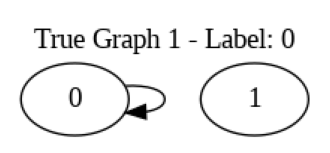

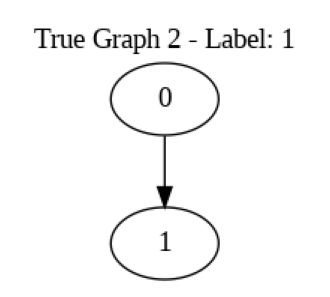

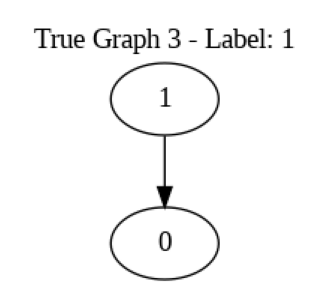

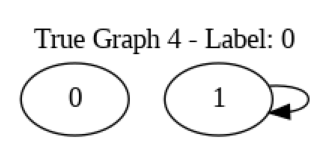

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import EdgeConv, global_mean_pool
import networkx as nx
from graphviz import Digraph
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Define the XOR dataset
class XORGraphDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.graphs = []
        self.labels = []

        # Add the four graphs and their labels
        self.add_graph([0, 1], [[0, 0]], 0)
        self.add_graph([0, 1], [[0, 1]], 1)
        self.add_graph([0, 1], [[1, 0]], 1)
        self.add_graph([0, 1], [[1, 1]], 0)

    def add_graph(self, nodes, edges, label):
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)
        y = torch.tensor([label], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        self.graphs.append(data)
        self.labels.append(label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

# Visualize graphs using NetworkX with directed edges and a compact layout
from graphviz import Digraph
def plotgraph(graphs, labels, title_prefix=''):
    for i, graph in enumerate(graphs):
        dot = Digraph(comment=f'{title_prefix} Graph {i+1}', engine='dot')
        x, edge_index = graph.x, graph.edge_index
        for node_id in range(x.shape[0]):
            dot.node(str(node_id), label=str(int(x[node_id].item())))
        for j in range(edge_index.shape[1]):
            src, dst = edge_index[0, j].item(), edge_index[1, j].item()
            dot.edge(str(src), str(dst))
        dot.attr(label=f'{title_prefix} Graph {i+1} - Label: {labels[i]}')
        dot.attr(labelloc='t')
        dot.render(f'{title_prefix}_graph_{i+1}', format='png', cleanup=True)
        plt.figure(figsize=(4, 4))
        img = plt.imread(f'{title_prefix}_graph_{i+1}.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Prepare the dataset and data loader
dataset = XORGraphDataset()
plotgraph(dataset.graphs, dataset.labels, "True")



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 000, Loss: 0.6933
Epoch: 010, Loss: 0.6872
Epoch: 020, Loss: 0.6598
Epoch: 030, Loss: 0.6081
Epoch: 040, Loss: 0.5821
Epoch: 050, Loss: 0.5619
Epoch: 060, Loss: 0.5464
Epoch: 070, Loss: 0.5349
Epoch: 080, Loss: 0.5263
Epoch: 090, Loss: 0.5196
Epoch: 100, Loss: 0.5143
Epoch: 110, Loss: 0.5100
Epoch: 120, Loss: 0.5065
Epoch: 130, Loss: 0.5035
Epoch: 140, Loss: 0.5010
Epoch: 150, Loss: 0.4989
Epoch: 160, Loss: 0.4971
Epoch: 170, Loss: 0.4955
Epoch: 180, Loss: 0.4942
Epoch: 190, Loss: 0.4929
Epoch: 200, Loss: 0.4919
Epoch: 210, Loss: 0.4909
Epoch: 220, Loss: 0.4900
Epoch: 230, Loss: 0.4893
Epoch: 240, Loss: 0.4886
Epoch: 250, Loss: 0.4879
Epoch: 260, Loss: 0.4873
Epoch: 270, Loss: 0.4868
Epoch: 280, Loss: 0.4863
Epoch: 290, Loss: 0.4859
Epoch: 300, Loss: 0.4855
Epoch: 310, Loss: 0.4851
Epoch: 320, Loss: 0.4847
Epoch: 330, Loss: 0.4844
Epoch: 340, Loss: 0.4841
Epoch: 350, Loss: 0.4838
Epoch: 360, Loss: 0.4836
Epoch: 370, Loss: 0.4833
Epoch: 380, Loss: 0.4831
Epoch: 390, Loss: 0.4829


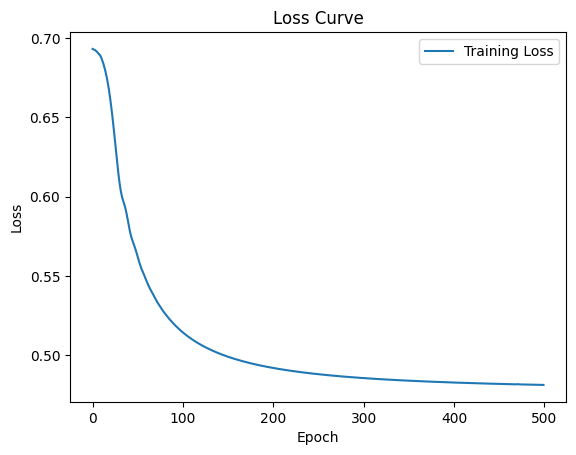

Accuracy: 0.7500
Graph 1 - Predicted label: 0
Graph 2 - Predicted label: 0
Graph 3 - Predicted label: 1
Graph 4 - Predicted label: 0


In [3]:

# Define the EdgeConv model
class EdgeNet(torch.nn.Module):
    def __init__(self):
        super(EdgeNet, self).__init__()
        self.conv1 = EdgeConv(torch.nn.Sequential(
            torch.nn.Linear(2, 16), torch.nn.ReLU(), torch.nn.Linear(16, 4)))
        self.conv2 = EdgeConv(torch.nn.Sequential(
            torch.nn.Linear(8, 16), torch.nn.ReLU(), torch.nn.Linear(16, 4)))
        self.fc = torch.nn.Linear(4, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with loss tracking
loss_values = []
model.train()
for epoch in range(500):
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')

# Plot the loss curve
plt.figure()
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Testing
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
accuracy = correct / len(loader.dataset)
print(f'Accuracy: {accuracy:.4f}')

# Generate responses on all 4 graphs
graphs = [
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 1]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 1]], dtype=torch.long).t().contiguous())
]

for i, graph in enumerate(graphs):
    graph = graph.to(device)
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax(dim=1)
        print(f'Graph {i+1} - Predicted label: {pred.item()}')


Epoch: 000, Loss: 0.6934
Epoch: 010, Loss: 0.6914
Epoch: 020, Loss: 0.6827
Epoch: 030, Loss: 0.6594
Epoch: 040, Loss: 0.6109
Epoch: 050, Loss: 0.5574
Epoch: 060, Loss: 0.5286
Epoch: 070, Loss: 0.4975
Epoch: 080, Loss: 0.4638
Epoch: 090, Loss: 0.4206
Epoch: 100, Loss: 0.3705
Epoch: 110, Loss: 0.3334
Epoch: 120, Loss: 0.3091
Epoch: 130, Loss: 0.2859
Epoch: 140, Loss: 0.2664
Epoch: 150, Loss: 0.2489
Epoch: 160, Loss: 0.2334
Epoch: 170, Loss: 0.2196
Epoch: 180, Loss: 0.2071
Epoch: 190, Loss: 0.1957
Epoch: 200, Loss: 0.1854
Epoch: 210, Loss: 0.1759
Epoch: 220, Loss: 0.1675
Epoch: 230, Loss: 0.1593
Epoch: 240, Loss: 0.1518
Epoch: 250, Loss: 0.1449
Epoch: 260, Loss: 0.1385
Epoch: 270, Loss: 0.1326
Epoch: 280, Loss: 0.1270
Epoch: 290, Loss: 0.1218
Epoch: 300, Loss: 0.1169
Epoch: 310, Loss: 0.1123
Epoch: 320, Loss: 0.1080
Epoch: 330, Loss: 0.1040
Epoch: 340, Loss: 0.1002
Epoch: 350, Loss: 0.0966
Epoch: 360, Loss: 0.0932
Epoch: 370, Loss: 0.0884
Epoch: 380, Loss: 0.0570
Epoch: 390, Loss: 0.0173


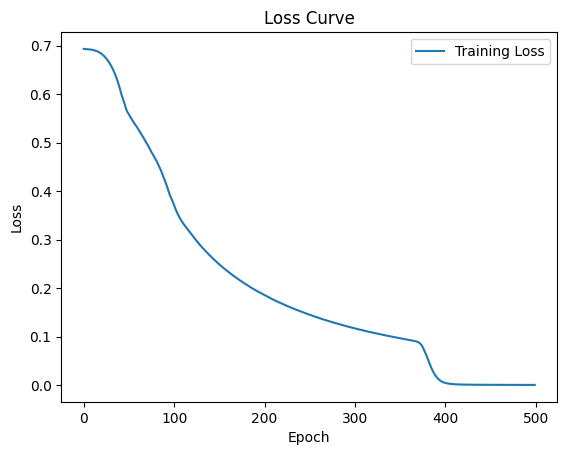

Accuracy: 1.0000
Graph 1 - Predicted label: 0
Graph 2 - Predicted label: 1
Graph 3 - Predicted label: 1
Graph 4 - Predicted label: 0


In [8]:
# Define the GAT model
from torch_geometric.nn import GATConv, global_mean_pool

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(1, 4, heads=2)
        self.conv2 = GATConv(8, 4, heads=2)
        self.fc = torch.nn.Linear(8, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)

loader = DataLoader(dataset, batch_size=4, shuffle=True)
# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with loss tracking
loss_values = []
model.train()
for epoch in range(500):
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')
# Plot the loss curve
plt.figure()
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Testing
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
accuracy = correct / len(loader.dataset)
print(f'Accuracy: {accuracy:.4f}')

# Generate responses on all 4 graphs
graphs = [
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 1]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 1]], dtype=torch.long).t().contiguous())
]

for i, graph in enumerate(graphs):
    graph = graph.to(device)
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax(dim=1)
        print(f'Graph {i+1} - Predicted label: {pred.item()}')
